In [3]:
from pathlib import Path
import numpy as np
import pandas as pd
import faiss

features_path = Path("data") / "batch_features"

In [4]:
import numpy as np
import pandas as pd

# Load all numpy files
features_list = [np.load(features_file) for features_file in sorted(features_path.glob("*.npy"))]

# Concatenate the features and store in a merged file
features = np.concatenate(features_list).astype(np.float32) # (n_images, 1024)

# Load all the photo IDs
photo_ids = pd.concat([pd.read_csv(ids_file) for ids_file in sorted(features_path.glob("*.csv"))])

In [5]:
n, d = features.shape # n: number of images, d: dimension of each image feature
index = faiss.IndexFlatIP(d) # build the index
index.add(features) # add vectors to the index

In [6]:
print(f"The index contains {index.ntotal} vectors.")

The index contains 14892 vectors.


In [7]:
index_npy_path = "index_features.index"
faiss.write_index(index, index_npy_path)

## Load CLIP

In [8]:
from utils.load_clip import load_clip_model
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

model, preprocess = load_clip_model("finetuned_RN50.pt")

c:\Users\LENOVO\Documents\Github\CS336.O11.KHCL\.venv\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


## Load dataset

In [9]:
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image

val_dataset_path = Path("splited_fashionIQ") / "val"

val_images_files = list(val_dataset_path.glob("*.png"))

print(f"Val images found: {len(val_images_files)}")

Val images found: 14892


In [10]:
import torch.nn.functional as F
import clip

def extract_query_features(query_path, text):
    query = Image.open(query_path)

    query_preprocessed = preprocess(query).unsqueeze(0).to(device)

    with torch.no_grad():
        text_features = model.encode_text(clip.tokenize(text).to(device))
        text_features /= text_features.norm(dim=-1, keepdim=True)

        image_features = model.encode_image(query_preprocessed)
        image_features /= image_features.norm(dim=-1, keepdim=True)

    combined_features = F.normalize(image_features + text_features, dim=-1)

    return combined_features.cpu().numpy()

In [11]:
# Load the query image
query_path = val_dataset_path / "B0083I6W08.png"
text = "is green with a four leaf clover"

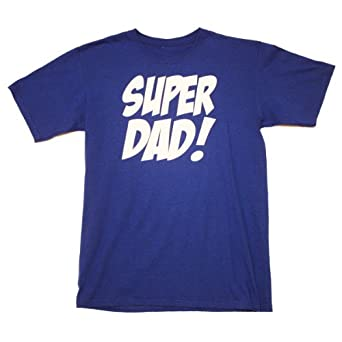

In [12]:
Image.open(query_path)

In [13]:
query_features = extract_query_features(query_path, text)

In [17]:
result = index.search(query_features, k=50)
print(result)

[{'image': 'B0083FXVDC.png', 'similarity': 0.2882038354873657}, {'image': 'B00640IQFQ.png', 'similarity': 0.35044360160827637}, {'image': 'B00CPSD8A4.png', 'similarity': 0.37793880701065063}, {'image': 'B004XJJRIU.png', 'similarity': 0.40575534105300903}, {'image': 'B002ZG8IIS.png', 'similarity': 0.40627503395080566}, {'image': 'B008DN1078.png', 'similarity': 0.40630531311035156}, {'image': 'B00BPCXXIS.png', 'similarity': 0.40814459323883057}, {'image': 'B00GH0TW42.png', 'similarity': 0.41295528411865234}, {'image': 'B002SVEKNW.png', 'similarity': 0.4198421835899353}, {'image': 'B00A3EZC4M.png', 'similarity': 0.420133113861084}, {'image': 'B00BIQADUW.png', 'similarity': 0.4218823313713074}, {'image': 'B002NB4I1Q.png', 'similarity': 0.4294382333755493}, {'image': 'B003PC479A.png', 'similarity': 0.43433135747909546}, {'image': 'B008R4XZ0I.png', 'similarity': 0.43450742959976196}, {'image': 'B004SAYJNW.png', 'similarity': 0.43511050939559937}, {'image': 'B007U4SBYG.png', 'similarity': 0.4

In [14]:
import faiss

index = faiss.read_index("index_features.index")

distances, indices = index.search(query_features, k=50)

# `I` contains the indices of the top 5 most similar images
print("Indices of the top 5 most similar images:", indices)

Indices of the top 5 most similar images: [[ 7332  4993 13147  3549  1546  7940 11913 14818  1432 10029 11723  1351
   2096  8507  3315  6837  5321  1026 14290  4570 11683 10901  2224  2309
   5370   752  4707  1381  2060  2234  7417   861  9896  5468 10565  4944
   6374  1136 12115  4367  4358 14874  9436 11353   834  1041 13018  9953
   4571  7241]]


In [21]:
photo_ids.iloc[7332]

image_id    B0083I6W08
Name: 0, dtype: object

Top 1 image name: B0083I6W08
Top 1 cosine sim: 0.2882038354873657


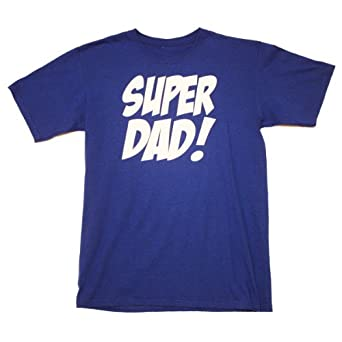

Top 2 image name: B00640XNUY
Top 2 cosine sim: 0.35044360160827637


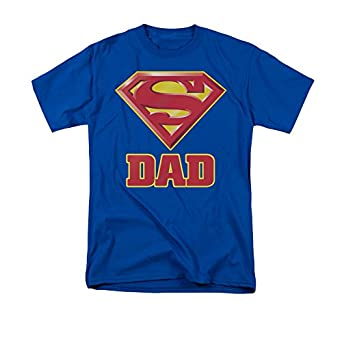

Top 3 image name: B00CPSDPCU
Top 3 cosine sim: 0.37793880701065063


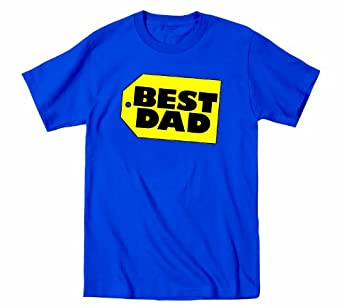

Top 4 image name: B004XKUY7M
Top 4 cosine sim: 0.40575534105300903


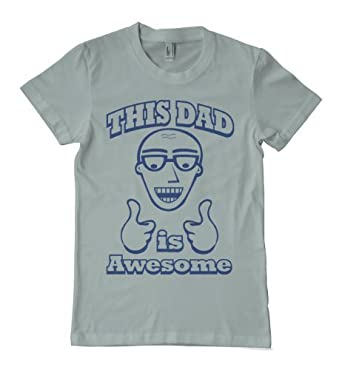

Top 5 image name: B002ZHUT16
Top 5 cosine sim: 0.40627503395080566


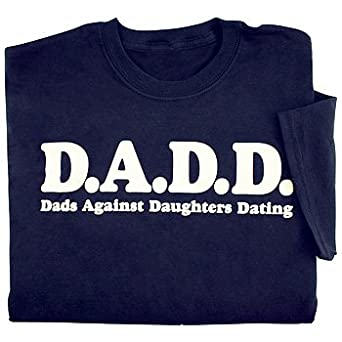

Top 6 image name: B008DO6OFK
Top 6 cosine sim: 0.40630531311035156


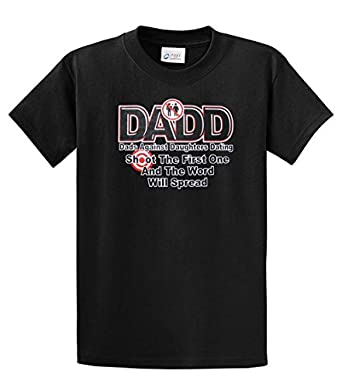

Top 7 image name: B00BPD4N5E
Top 7 cosine sim: 0.40814459323883057


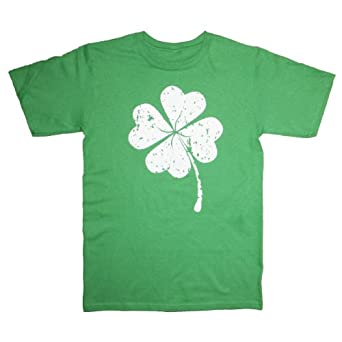

Top 8 image name: B00GH7IYIU
Top 8 cosine sim: 0.41295528411865234


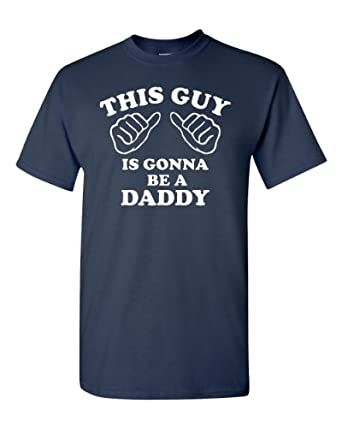

Top 9 image name: B002SVQIT6
Top 9 cosine sim: 0.4198421835899353


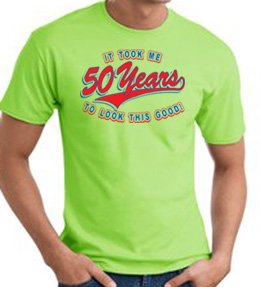

Top 10 image name: B00A3F9MS8
Top 10 cosine sim: 0.420133113861084


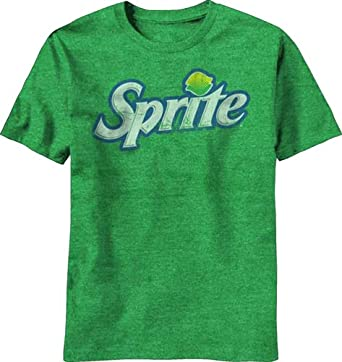

Top 11 image name: B00BIQKAWS
Top 11 cosine sim: 0.4218823313713074


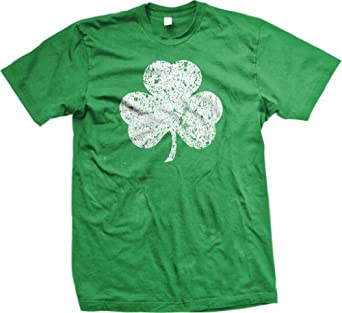

Top 12 image name: B002NCIATQ
Top 12 cosine sim: 0.4294382333755493


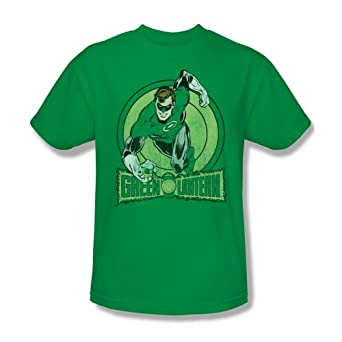

Top 13 image name: B003PD0G30
Top 13 cosine sim: 0.43433135747909546


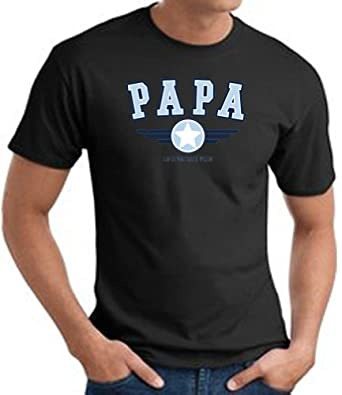

Top 14 image name: B008R567RU
Top 14 cosine sim: 0.43450742959976196


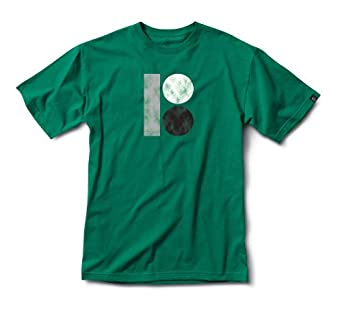

Top 15 image name: B004SBSY3W
Top 15 cosine sim: 0.43511050939559937


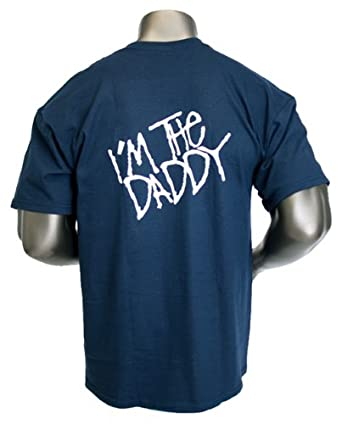

Top 16 image name: B007U586UE
Top 16 cosine sim: 0.4352264404296875


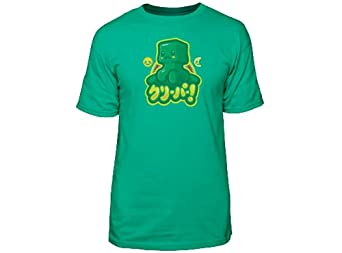

Top 17 image name: B006L28DQY
Top 17 cosine sim: 0.4353022575378418


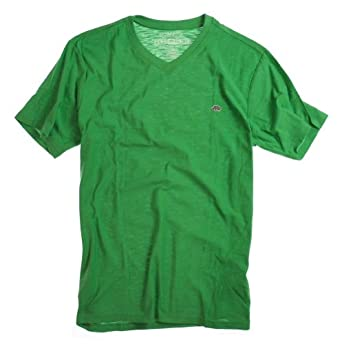

Top 18 image name: B001THROSE
Top 18 cosine sim: 0.43608248233795166


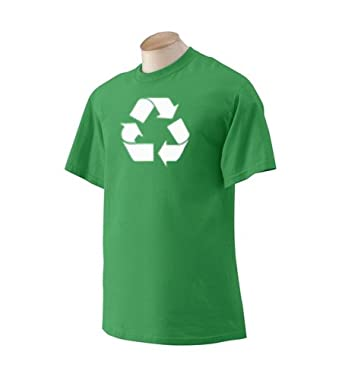

Top 19 image name: B00EH92VEI
Top 19 cosine sim: 0.43697094917297363


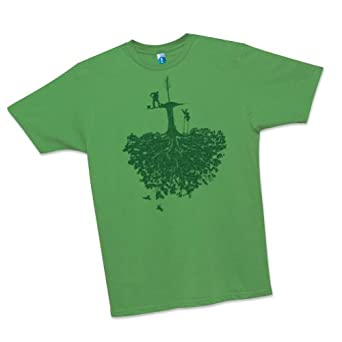

Top 20 image name: B005OCBLLG
Top 20 cosine sim: 0.43826913833618164


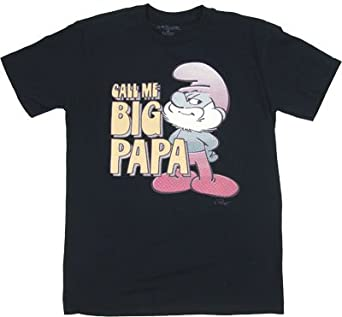

Top 21 image name: B00BHKFFAW
Top 21 cosine sim: 0.44154196977615356


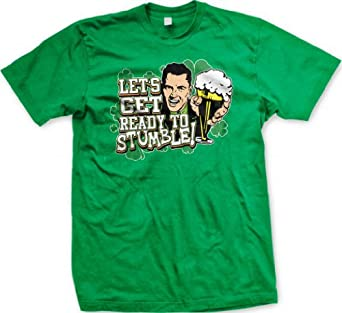

Top 22 image name: B00AWSCTYU
Top 22 cosine sim: 0.44225215911865234


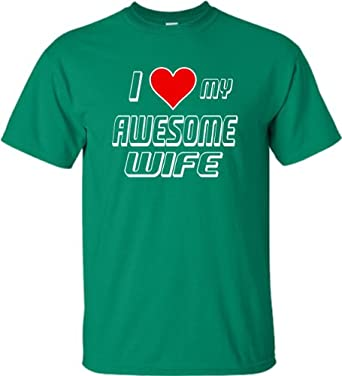

Top 23 image name: B003URVV8A
Top 23 cosine sim: 0.44316136837005615


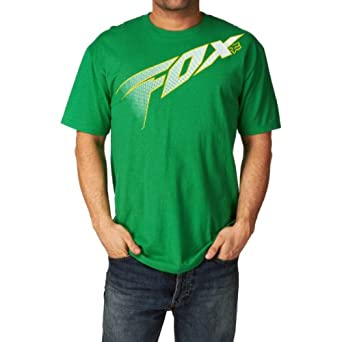

Top 24 image name: B003XT6BF8
Top 24 cosine sim: 0.4432241916656494


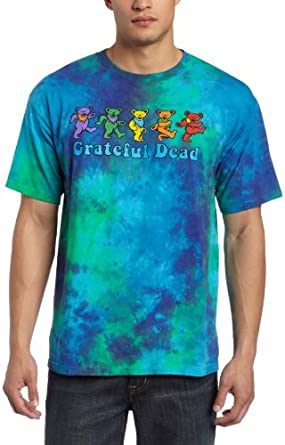

Top 25 image name: B006MV5MV8
Top 25 cosine sim: 0.44581449031829834


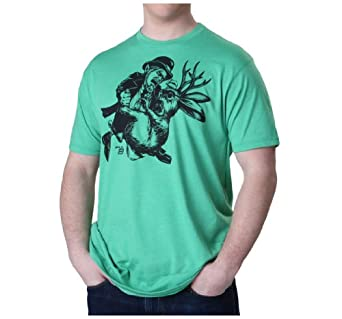

Top 26 image name: B001CK7TGA
Top 26 cosine sim: 0.4462771415710449


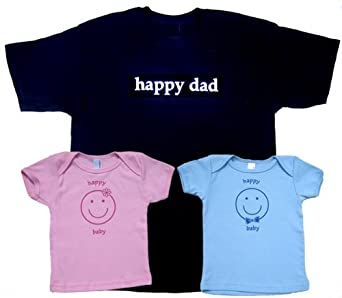

Top 27 image name: B005TF98AE
Top 27 cosine sim: 0.44832098484039307


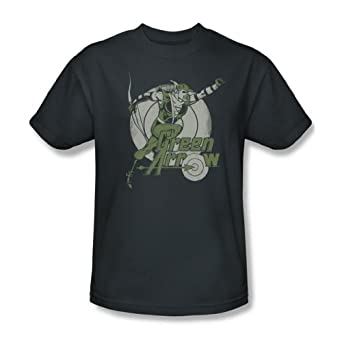

Top 28 image name: B002Q4VHMS
Top 28 cosine sim: 0.4484655261039734


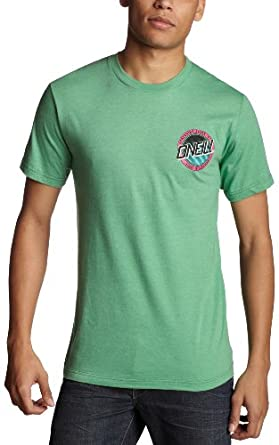

Top 29 image name: B003NGJPX6
Top 29 cosine sim: 0.4493259787559509


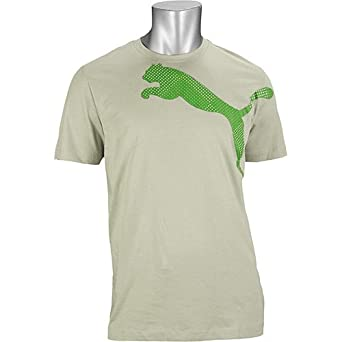

Top 30 image name: B003V75YYQ
Top 30 cosine sim: 0.45168960094451904


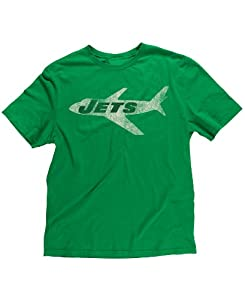

Top 31 image name: B0084SUJ92
Top 31 cosine sim: 0.45278650522232056


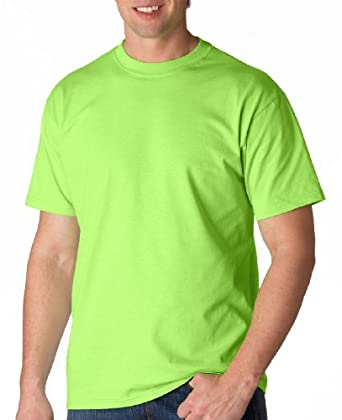

Top 32 image name: B001KLJJNM
Top 32 cosine sim: 0.45278650522232056


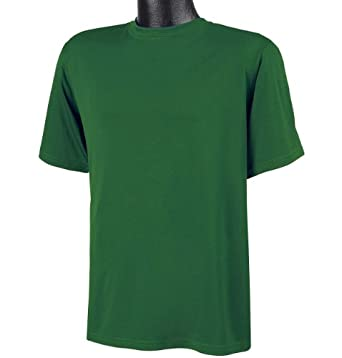

Top 33 image name: B009Z3YN4W
Top 33 cosine sim: 0.4547039270401001


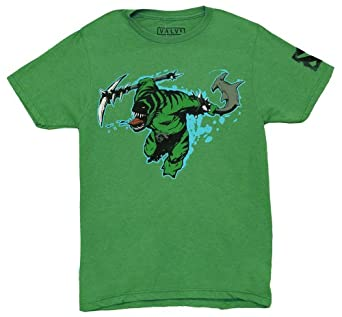

Top 34 image name: B006RRLUYA
Top 34 cosine sim: 0.4556812047958374


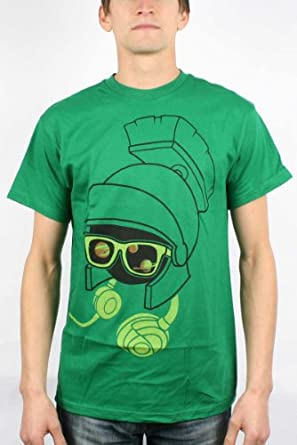

Top 35 image name: B00ALS5IM6
Top 35 cosine sim: 0.4560607075691223


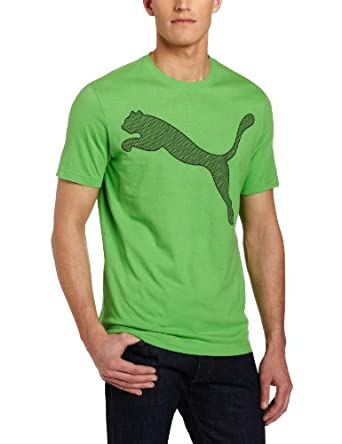

Top 36 image name: B0062B5JQQ
Top 36 cosine sim: 0.45658499002456665


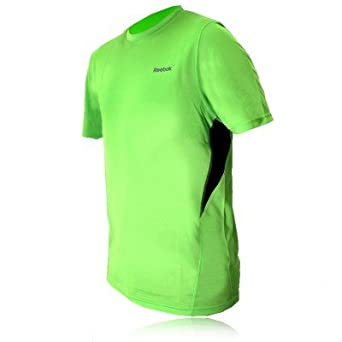

Top 37 image name: B007IJZ2KO
Top 37 cosine sim: 0.4583815932273865


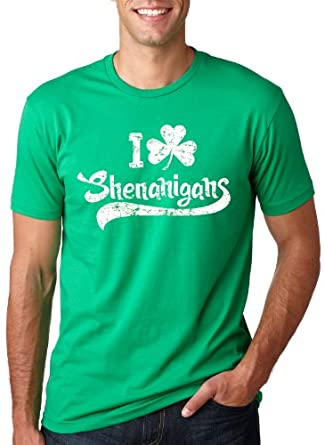

Top 38 image name: B0026YCH54
Top 38 cosine sim: 0.4607388377189636


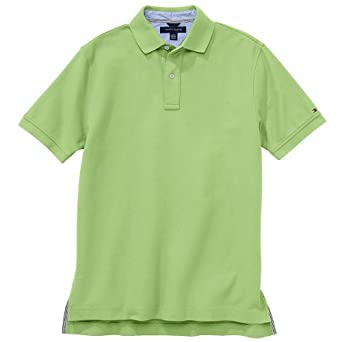

Top 39 image name: B00BUROKQM
Top 39 cosine sim: 0.461638867855072


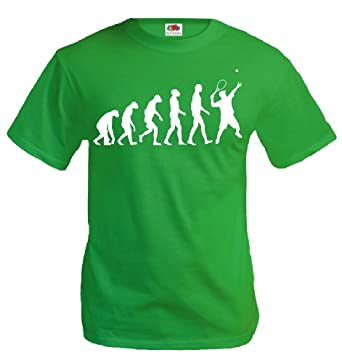

Top 40 image name: B005JQ5YBU
Top 40 cosine sim: 0.46178746223449707


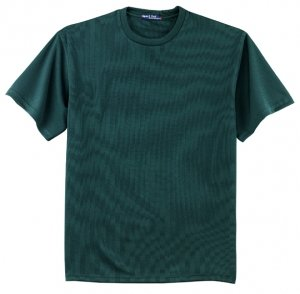

Top 41 image name: B005JFAIQ2
Top 41 cosine sim: 0.4618186950683594


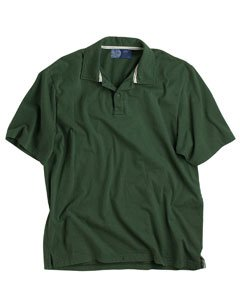

Top 42 image name: B00GXYOGG6
Top 42 cosine sim: 0.46223747730255127


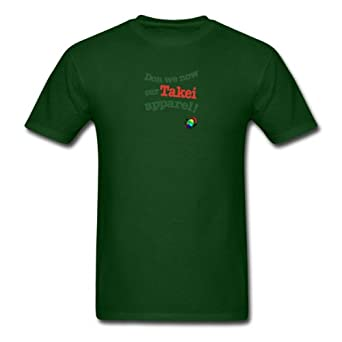

Top 43 image name: B009H2NZT0
Top 43 cosine sim: 0.46263331174850464


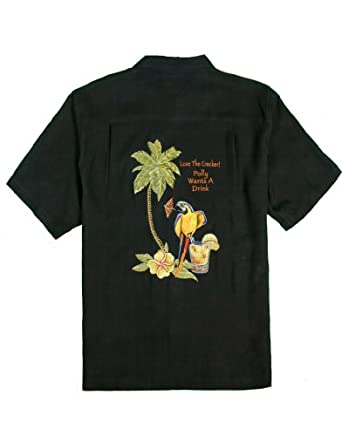

Top 44 image name: B00B8ACUXQ
Top 44 cosine sim: 0.4634578824043274


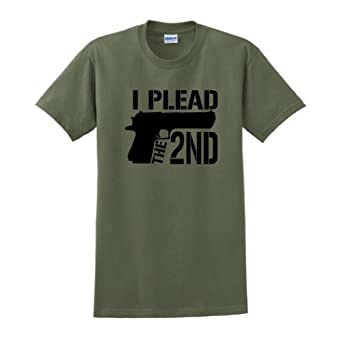

Top 45 image name: B001HKGHVS
Top 45 cosine sim: 0.46366602182388306


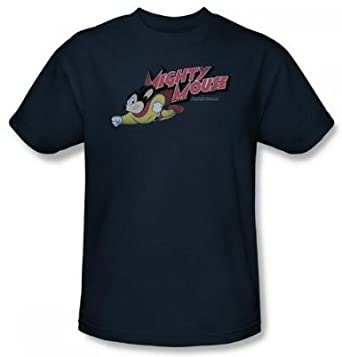

Top 46 image name: B001UA59E6
Top 46 cosine sim: 0.46371006965637207


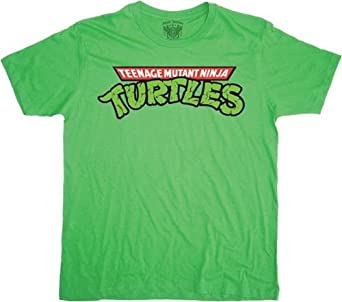

Top 47 image name: B00CLCHVSY
Top 47 cosine sim: 0.4642457962036133


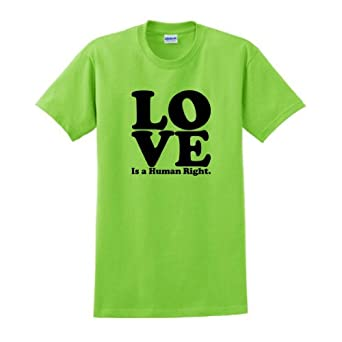

Top 48 image name: B00A0NDRUC
Top 48 cosine sim: 0.46472275257110596


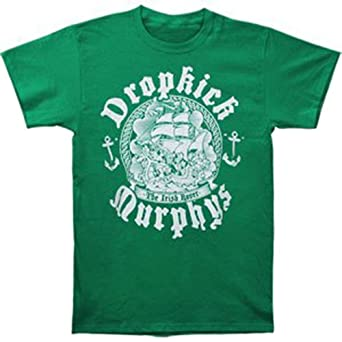

Top 49 image name: B005OCCSCC
Top 49 cosine sim: 0.46502983570098877


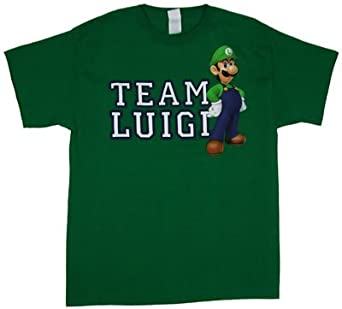

Top 50 image name: B0081GBQFS
Top 50 cosine sim: 0.4650551676750183


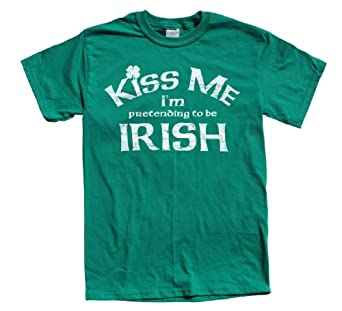

In [15]:
from IPython.display import display

for i, idx in enumerate(indices[0]):
    print(f"Top {i+1} image name: {photo_ids.iloc[idx].values[0]}")
    print(f"Top {i+1} cosine sim: {1 - distances[0][i]}")
    filename = photo_ids.iloc[idx].values[0] + ".png"
    display(Image.open(val_dataset_path / filename))